# PhiUSIIL Phishing URL — Training & Evaluation (Full-feature vs URL-only)

Notebook ini adalah *upgrade* dari versi sebelumnya: menambahkan **leakage check**, **domain-split evaluation**, dan **ablation** agar hasil lebih realistis untuk kebutuhan laporan/jurnal.

**Target**: deteksi URL phishing berbasis machine learning + artifacts untuk dipakai di Flask.

> Konvensi label dataset: `0 = phishing`, `1 = legitimate`.


In [1]:

# If needed (optional):
# !pip install -r requirements.txt

import os, json, math, re, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception as e:
    XGB_OK = False
    print("XGBoost tidak tersedia, model XGB akan di-skip:", e)


## 1) Load dataset

In [2]:

DATASET_PATH = Path("dataset/PhiUSIIL_Phishing_URL_Dataset.csv")
if not DATASET_PATH.exists():
    # fallback: jika user taruh CSV di root
    alt = Path("PhiUSIIL_Phishing_URL_Dataset.csv")
    if alt.exists():
        DATASET_PATH = alt

print("Dataset path:", DATASET_PATH.resolve())
df = pd.read_csv(DATASET_PATH)
print("Shape:", df.shape)
display(df.head(3))


Dataset path: D:\1 Data Asus AA\file kuliah\Semester 5\PRAKTIKUM PEMBELAJARAN MESIN\Tugas besar (UAS)\Program v5\dataset\PhiUSIIL_Phishing_URL_Dataset.csv
Shape: (235795, 56)


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1


,proportion
y_phishing,
0,0.571895
1,0.428105


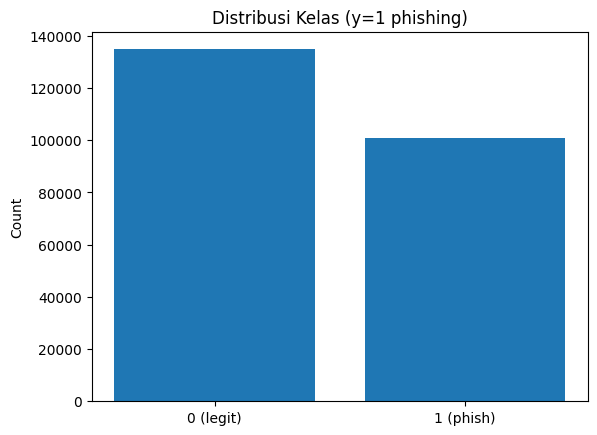

In [3]:

# Target: y=1 phishing, y=0 legitimate
# Dataset asli: label 0=phishing, 1=legitimate
y = (df["label"].astype(int) == 0).astype(int)

# quick check distribusi
dist = y.value_counts(normalize=True).rename_axis("y_phishing").to_frame("proportion")
display(dist)

plt.figure()
plt.title("Distribusi Kelas (y=1 phishing)")
plt.bar(["0 (legit)","1 (phish)"], [int((y==0).sum()), int((y==1).sum())])
plt.ylabel("Count")
plt.show()


## 2) Full-feature vs URL-only

- **Full-feature**: memakai 51 fitur numerik dari dataset (tanpa URL/Domain/TLD string).
- **URL-only**: fitur diekstraksi dari *URL string* saja (bisa dipakai untuk URL di luar dataset), termasuk fitur kebaruan berbasis parsing (tanpa crawling).

In [4]:

# Full-feature columns (ambil semua numerik kecuali label + non-numerik)
drop_cols = {"FILENAME","URL","Domain","TLD","Title","label"}
full_numeric = [c for c in df.columns if c not in drop_cols]
# keep only numeric-like
full_numeric = [c for c in full_numeric if pd.api.types.is_numeric_dtype(df[c])]
print("Full numeric features:", len(full_numeric))
print(full_numeric[:20], "...")


Full numeric features: 50
['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL'] ...


## 3) Leakage / shortcut check (penting untuk hasil 100%)

Jika ada fitur yang hampir menentukan kelas secara langsung (misal pada kelas tertentu nilainya *konstan*), model bisa mendapat akurasi 100% tetapi tidak realistis untuk URL baru. Bagian ini membantu mendeteksi fitur semacam itu.

In [5]:

def leakage_report(df, y, features):
    out = []
    for c in features:
        s0 = df.loc[y==0, c]
        s1 = df.loc[y==1, c]
        out.append({
            "feature": c,
            "nunique_legit(y=0)": int(s0.nunique(dropna=False)),
            "nunique_phish(y=1)": int(s1.nunique(dropna=False)),
            "legit_min": float(s0.min()) if len(s0) else None,
            "legit_max": float(s0.max()) if len(s0) else None,
            "phish_min": float(s1.min()) if len(s1) else None,
            "phish_max": float(s1.max()) if len(s1) else None,
        })
    rep = pd.DataFrame(out)
    # suspicious: satu kelas punya nunique=1, kelas lain lebih beragam
    rep["suspicious"] = (
        ((rep["nunique_legit(y=0)"]==1) & (rep["nunique_phish(y=1)"]>5)) |
        ((rep["nunique_phish(y=1)"]==1) & (rep["nunique_legit(y=0)"]>5))
    )
    return rep.sort_values(["suspicious","nunique_legit(y=0)","nunique_phish(y=1)"], ascending=[False,True,True])

rep = leakage_report(df, y, full_numeric)
display(rep.head(25))
print("Jumlah fitur suspicious:", int(rep["suspicious"].sum()))


,feature,nunique_legit(y=0),nunique_phish(y=1),legit_min,legit_max,phish_min,phish_max,suspicious
10,NoOfObfuscatedChar,1,20,0.0,0.0,0.000000,447.000,True
16,NoOfEqualsInURL,1,25,0.0,0.0,0.000000,176.000,True
18,NoOfAmpersandInURL,1,31,0.0,0.0,0.000000,149.000,True
11,ObfuscationRatio,1,146,0.0,0.0,0.000000,0.348,True
3,URLSimilarityIndex,1,36360,100.0,100.0,0.155574,100.000,True
2,IsDomainIP,1,2,0.0,0.0,0.000000,1.000,False
9,HasObfuscation,1,2,0.0,0.0,0.000000,1.000,False
21,IsHTTPS,1,2,1.0,1.0,0.000000,1.000,False
17,NoOfQMarkInURL,1,5,0.0,0.0,0.000000,4.000,False
24,HasTitle,2,2,0.0,1.0,0.000000,1.000,False


Jumlah fitur suspicious: 5


In [6]:

# Contoh "rule-based shortcut" sederhana untuk beberapa fitur suspicious:
candidates = rep.loc[rep["suspicious"], "feature"].head(10).tolist()
print("Candidates:", candidates)

def eval_rule(feature, rule_fn):
    pred = rule_fn(df[feature])
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    return {"feature": feature, "acc": acc, "f1": f1, "precision": prec, "recall": rec}

rules = []
for c in candidates:
    # heuristic: jika phishing kelasnya punya nilai konstan, pakai threshold median untuk contoh
    s = df[c]
    if s.nunique() <= 10:
        # binary-like
        rules.append(eval_rule(c, lambda x: (x==x.value_counts().idxmax()).astype(int)))  # dummy
    else:
        thr = s.median()
        rules.append(eval_rule(c, lambda x: (x < thr).astype(int)))
pd.DataFrame(rules).sort_values("f1", ascending=False).head(10)


Candidates: ['NoOfObfuscatedChar', 'NoOfEqualsInURL', 'NoOfAmpersandInURL', 'ObfuscationRatio', 'URLSimilarityIndex']


,feature,acc,f1,precision,recall
4,URLSimilarityIndex,0.996667,0.996092,1.0,0.992214
0,NoOfObfuscatedChar,0.571895,0.000000,0.0,0.000000
1,NoOfEqualsInURL,0.571895,0.000000,0.0,0.000000
2,NoOfAmpersandInURL,0.571895,0.000000,0.0,0.000000
3,ObfuscationRatio,0.571895,0.000000,0.0,0.000000


## 4) Split strategi

- **Random stratified split**: umum dipakai tetapi bisa over-estimate jika ada kemiripan domain antar train/test.
- **Domain-split**: memisahkan berdasarkan *registered domain* (lebih mirip skenario URL baru dari domain berbeda).

Untuk domain extraction disarankan `tldextract` (offline).

In [7]:

# Domain grouping using tldextract (offline snapshot)
import tldextract
from urllib.parse import urlparse

_TLD = tldextract.TLDExtract(suffix_list_urls=None)

def registered_domain(url: str) -> str:
    try:
        u = str(url).strip()
        if not re.match(r"^https?://", u.lower()):
            u = "http://" + u
        host = urlparse(u).netloc
        if "@" in host:
            host = host.split("@",1)[1]
        host = host.split(":")[0]
        ex = _TLD(host)
        rd = ex.registered_domain
        return (rd or host).lower()
    except Exception:
        return "unknown"

groups = df["URL"].astype(str).apply(registered_domain)
print("Unique registered domains:", groups.nunique())
groups.value_counts().head(10)


Unique registered domains: 175509


URL
web.app            5754
firebaseapp.com    5594
repl.co            3754
weeblysite.com     3097
ipfs.io            1559
workers.dev        1438
square.site        1199
dweb.link           975
xsph.ru             928
pantheonsite.io     900
Name: count, dtype: int64

## 5) Train & evaluate models — Full-feature

In [8]:

def build_models():
    models = {}
    models["LogReg"] = LogisticRegression(max_iter=2500, class_weight="balanced", n_jobs=None)
    models["RandomForest"] = RandomForestClassifier(
        n_estimators=600, random_state=SEED, class_weight="balanced_subsample", n_jobs=-1
    )
    if XGB_OK:
        models["XGBoost"] = XGBClassifier(
            n_estimators=700,
            learning_rate=0.06,
            max_depth=6,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=1.0,
            random_state=SEED,
            n_jobs=-1,
            eval_metric="logloss",
        )
    return models

def eval_split(X_train, X_test, y_train, y_test, model_name, model, scaler_for_lr=True):
    num_cols = list(X_train.columns)
    if model_name == "LogReg" and scaler_for_lr:
        pre = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="drop")
        pipe = Pipeline([("prep", pre), ("clf", model)])
    else:
        pipe = Pipeline([("prep", "passthrough"), ("clf", model)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]  # y=1 phishing
    # find best thr by F1
    thrs = np.linspace(0.05, 0.95, 91)
    best_thr, best_f1 = 0.5, -1
    for t in thrs:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_test, pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, t
    pred = (proba >= best_thr).astype(int)
    return {
        "model": model_name,
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "best_thr_f1": float(best_thr),
        "f1": f1_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "accuracy": accuracy_score(y_test, pred),
        "pipe": pipe,
    }

def run_experiment_full(X, y, groups=None, title=""):
    models = build_models()
    rows = []
    pipes = {}
    if groups is None:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
    else:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        tr_idx, te_idx = next(gss.split(X, y, groups=groups))
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    for name, mdl in models.items():
        res = eval_split(X_tr, X_te, y_tr, y_te, name, mdl)
        pipes[name] = res.pop("pipe")
        rows.append(res)
    out = pd.DataFrame(rows).sort_values(["f1","pr_auc","roc_auc"], ascending=False)
    print(title)
    display(out)
    return out, pipes, (X_tr, X_te, y_tr, y_te)

X_full = df[full_numeric].copy()
res_full_random, pipes_full_random, split_full_random = run_experiment_full(X_full, y, groups=None, title="Random split — Full-feature")
res_full_domain, pipes_full_domain, split_full_domain = run_experiment_full(X_full, y, groups=groups, title="Domain split — Full-feature")


Random split — Full-feature


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
0,LogReg,1.0,1.0,0.12,1.0,1.0,1.0,1.0
1,RandomForest,1.0,1.0,0.20,1.0,1.0,1.0,1.0
2,XGBoost,1.0,1.0,0.05,1.0,1.0,1.0,1.0


Domain split — Full-feature


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
1,RandomForest,1.000000,1.000000,0.22,1.0000,1.000000,1.000000,1.000000
2,XGBoost,1.000000,1.000000,0.12,1.0000,1.000000,1.000000,1.000000
0,LogReg,0.999999,0.999998,0.13,0.9999,0.999933,0.999867,0.999928


## 6) Ablation — buang fitur yang berpotensi leakage

Tujuan: cek apakah performa masih stabil ketika fitur shortcut dihapus. Ini biasanya **menurunkan** skor dari 100% ke angka yang lebih realistis.

In [9]:

# Candidate leakage list (akan di-drop jika ada)
LEAKY_FEATURES = [
    "URLSimilarityIndex",
    "CharContinuationRate",
    "TLDLegitimateProb",
    "URLCharProb",
    "IsHTTPS",
    "IsDomainIP",
    "HasObfuscation",
    "NoOfObfuscatedChar",
    "ObfuscationRatio",
    "NoOfQMarkInURL",
    "NoOfAmpersandInURL",
    "NoOfEqualsInURL",
    # tambahkan jika perlu:
    "LineOfCode", "LargestLineLength",
    "URLTitleMatchScore", "DomainTitleMatchScore",
]

full_ablate = [c for c in full_numeric if c not in LEAKY_FEATURES]
print("Full ablated features:", len(full_ablate))

X_full_ab = df[full_ablate].copy()
res_ab_random, pipes_ab_random, _ = run_experiment_full(X_full_ab, y, groups=None, title="Random split — Full-feature (ablated)")
res_ab_domain, pipes_ab_domain, _ = run_experiment_full(X_full_ab, y, groups=groups, title="Domain split — Full-feature (ablated)")


Full ablated features: 34
Random split — Full-feature (ablated)


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
2,XGBoost,0.999996,0.999995,0.15,0.999430,0.999356,0.999505,0.999512
1,RandomForest,0.999972,0.999963,0.39,0.997993,0.998414,0.997573,0.998282
0,LogReg,0.999856,0.999847,0.70,0.995783,0.997416,0.994155,0.996395


Domain split — Full-feature (ablated)


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
2,XGBoost,0.999986,0.999977,0.26,0.998867,0.998934,0.998800,0.999190
1,RandomForest,0.999967,0.999942,0.35,0.997467,0.997866,0.997068,0.998188
0,LogReg,0.999721,0.999617,0.54,0.994102,0.994135,0.994069,0.995781


## 7) URL-only feature engineering (bisa untuk URL di luar dataset)

Di sini kita buat fitur dari `URL` saja (tanpa crawling), termasuk:
- panjang URL/domain
- jumlah digit/simbol
- TLD
- entropy URL
- keyword phishing (login, verify, bank, dll)
- shortener domain

Fitur ini lebih cocok untuk deployment real-world.

In [15]:

import ipaddress
from urllib.parse import urlparse

SHORTENER_DOMAINS = {
    "bit.ly", "tinyurl.com", "t.co", "goo.gl", "is.gd", "cutt.ly", "buff.ly",
    "rebrand.ly", "ow.ly", "lnkd.in", "rb.gy"
}

SUSPICIOUS_KEYWORDS = [
    "login", "verify", "verification", "secure", "account", "update", "confirm",
    "signin", "sign-in", "bank", "payment", "wallet", "support", "webscr", "password"
]

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    freq = {}
    for ch in s:
        freq[ch] = freq.get(ch, 0) + 1
    n = len(s)
    ent = 0.0
    for c in freq.values():
        p = c / n
        ent -= p * math.log2(p)
    return float(ent)

def normalize_url(u: str) -> str:
    if u is None:
        return ""
    u = str(u).strip().replace(" ", "").lower()
    if len(u) > 1 and u.endswith("/"):
        u = u[:-1]
    return u

def urlonly_features(url: str) -> dict:
    u = normalize_url(url)
    parsed = urlparse(u if re.match(r"^https?://", u) else ("http://" + u))
    scheme = parsed.scheme or ""
    netloc = parsed.netloc or ""
    path = parsed.path or ""
    query = parsed.query or ""

    if "@" in netloc:
        netloc = netloc.split("@", 1)[1]

    host = netloc
    has_port = 0
    if ":" in host:
        host = host.split(":", 1)[0]
        has_port = 1

    ex = _TLD(host)
    tld = (ex.suffix or "").lower()
    domain = ".".join([p for p in [ex.domain, ex.suffix] if p]).lower()

    url_len = len(u)
    domain_len = len(domain)
    is_https = 1 if scheme.lower() == "https" else 0

    is_domain_ip = 0
    try:
        ipaddress.ip_address(host)
        is_domain_ip = 1
    except Exception:
        is_domain_ip = 0

    n_sub = 0 if (ex.subdomain or "").strip()=="" else len([x for x in ex.subdomain.split(".") if x])

    letters = sum(ch.isalpha() for ch in u)
    digits = sum(ch.isdigit() for ch in u)
    specials = max(url_len - letters - digits, 0)

    kw_hits = 0
    kw_flags = {}
    lower = u.lower()
    for kw in SUSPICIOUS_KEYWORDS:
        key = f"kw_{re.sub(r'[^a-z0-9]+','_',kw)}"
        hit = 1 if kw in lower else 0
        kw_flags[key] = hit
        kw_hits += hit

    feats = {
        "url_length": float(url_len),
        "domain_length": float(domain_len),
        "is_https": float(is_https),
        "is_domain_ip": float(is_domain_ip),
        "tld": str(tld if tld else "unknown"),
        "tld_length": float(len(tld) if tld else 0),
        "num_subdomains": float(n_sub),
        "has_port": float(has_port),
        "path_length": float(len(path)),
        "query_length": float(len(query)),
        "letters_count": float(letters),
        "digits_count": float(digits),
        "specials_count": float(specials),
        "letter_ratio": float(letters / url_len if url_len else 0.0),
        "digit_ratio": float(digits / url_len if url_len else 0.0),
        "special_ratio": float(specials / url_len if url_len else 0.0),
        "count_dot": float(u.count(".")),
        "count_hyphen": float(u.count("-")),
        "count_at": float(u.count("@")),
        "count_qmark": float(u.count("?")),
        "count_equal": float(u.count("=")),
        "count_ampersand": float(u.count("&")),
        "count_percent": float(u.count("%")),
        "count_slash": float(u.count("/")),
        "count_underscore": float(u.count("_")),
        "count_hash": float(u.count("#")),
        "has_punycode": float(1 if "xn--" in u else 0),
        "url_entropy": float(shannon_entropy(u)),
        "is_shortener": float(1 if domain in SHORTENER_DOMAINS else 0),
        "suspicious_kw_count": float(kw_hits),
    }
    feats.update({k: float(v) for k, v in kw_flags.items()})
    return feats

# Build URL-only feature matrix
X_url = pd.DataFrame([urlonly_features(u) for u in df["URL"].astype(str).tolist()])

# Ensure tld is object dtype (categorical), others are numeric
X_url["tld"] = X_url["tld"].astype("object")
numeric_cols = [c for c in X_url.columns if c != "tld"]
for c in numeric_cols:
    X_url[c] = pd.to_numeric(X_url[c], errors='coerce').fillna(0.0)

print("X_url shape:", X_url.shape)
display(X_url.head(3))



X_url shape: (235795, 45)


,url_length,domain_length,is_https,is_domain_ip,tld,tld_length,num_subdomains,has_port,path_length,query_length,...,kw_update,kw_confirm,kw_signin,kw_sign_in,kw_bank,kw_payment,kw_wallet,kw_support,kw_webscr,kw_password
0,32.0,20.0,1.0,0.0,com,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,24.0,12.0,1.0,0.0,de,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,18.0,1.0,0.0,co.uk,5.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:

# Identify categorical/numeric for URL-only
cat_cols = [c for c in X_url.columns if X_url[c].dtype == "object"]
num_cols = [c for c in X_url.columns if c not in cat_cols]
print("Categorical:", cat_cols)
print("Numeric:", len(num_cols))

from sklearn.preprocessing import OneHotEncoder

def eval_split_urlonly(X_train, X_test, y_train, y_test, model_name, model):
    # Identify categorical and numeric columns
    cat = [c for c in X_train.columns if X_train[c].dtype == "object"]
    num = [c for c in X_train.columns if c not in cat]

    if model_name == "LogReg":
        pre = ColumnTransformer(
            [("num", StandardScaler(), num),
             ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat)],
            remainder="drop"
        )
    else:
        pre = ColumnTransformer(
            [("num", "passthrough", num),
             ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat)],
            remainder="drop"
        )

    pipe = Pipeline([("prep", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    # best thr
    thrs = np.linspace(0.05, 0.95, 91)
    best_thr, best_f1 = 0.5, -1
    for t in thrs:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_test, pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, t
    pred = (proba >= best_thr).astype(int)
    return {
        "model": model_name,
        "roc_auc": roc_auc_score(y_test, proba),
        "pr_auc": average_precision_score(y_test, proba),
        "best_thr_f1": float(best_thr),
        "f1": f1_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "accuracy": accuracy_score(y_test, pred),
        "pipe": pipe,
    }

def run_experiment_urlonly(X, y, groups=None, title=""):
    models = build_models()
    rows = []
    pipes = {}
    if groups is None:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
    else:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
        tr_idx, te_idx = next(gss.split(X, y, groups=groups))
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    for name, mdl in models.items():
        res = eval_split_urlonly(X_tr, X_te, y_tr, y_te, name, mdl)
        pipes[name] = res.pop("pipe")
        rows.append(res)
    out = pd.DataFrame(rows).sort_values(["f1","pr_auc","roc_auc"], ascending=False)
    print(title)
    display(out)
    return out, pipes, (X_tr, X_te, y_tr, y_te)

res_url_random, pipes_url_random, split_url_random = run_experiment_urlonly(X_url, y, groups=None, title="Random split — URL-only")
res_url_domain, pipes_url_domain, split_url_domain = run_experiment_urlonly(X_url, y, groups=groups, title="Domain split — URL-only")



Categorical: ['tld']
Numeric: 44
Random split — URL-only


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
2,XGBoost,0.998370,0.998625,0.49,0.995476,0.999202,0.991778,0.996141
1,RandomForest,0.998065,0.998285,0.60,0.994556,0.998253,0.990886,0.995356
0,LogReg,0.996466,0.997337,0.40,0.991241,0.995950,0.986577,0.992536


Domain split — URL-only


,model,roc_auc,pr_auc,best_thr_f1,f1,precision,recall,accuracy
2,XGBoost,0.997819,0.997858,0.25,0.993645,0.997515,0.989804,0.995471
1,RandomForest,0.997377,0.997309,0.57,0.992734,0.997578,0.987938,0.994827
0,LogReg,0.995246,0.995879,0.38,0.988453,0.992939,0.984006,0.991776


## 8) Pilih model terbaik & simpan artifacts

Rekomendasi untuk deployment real-world: gunakan **URL-only model** yang performanya paling stabil di **domain-split**.

Artifacts yang disimpan:
- `model_pipeline.joblib` + `feature_schema.json` (full-feature)
- `model_pipeline_ablation.joblib` + `feature_schema_ablation.json`
- `model_urlonly.joblib` + `feature_schema_urlonly.json`
- `best_threshold*.json`, `metrics*.json`, `versions*.json`
- `feature_dict_*.json` (opsional untuk UI)

In [17]:

import joblib
import platform
import sklearn

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

def save_versions(path: Path):
    ver = {
        "python": platform.python_version(),
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "scikit_learn": sklearn.__version__,
    }
    if XGB_OK:
        import xgboost
        ver["xgboost"] = xgboost.__version__
    path.write_text(json.dumps(ver, indent=2), encoding="utf-8")

def pick_best(df_metrics: pd.DataFrame, prefer="f1"):
    # prefer f1 then pr_auc then roc_auc
    d = df_metrics.sort_values([prefer, "pr_auc", "roc_auc"], ascending=False).reset_index(drop=True)
    return d.loc[0, "model"]

def export_schema(path: Path, used_features: list):
    payload = {"used_features": list(used_features)}
    path.write_text(json.dumps(payload, indent=2), encoding="utf-8")

def export_threshold(path: Path, best_model: str, best_thr: float):
    payload = {"best_model": best_model, "best_threshold_by_f1": float(best_thr)}
    path.write_text(json.dumps(payload, indent=2), encoding="utf-8")

def export_metrics(path: Path, df_metrics: pd.DataFrame):
    path.write_text(df_metrics.to_json(orient="records", indent=2), encoding="utf-8")

# --- Full-feature (random) choose best just for reference ---
best_full = pick_best(res_full_random, prefer="f1")
thr_full = float(res_full_random.set_index("model").loc[best_full, "best_thr_f1"])
pipe_full = pipes_full_random[best_full]

joblib.dump(pipe_full, ARTIFACTS_DIR / "model_pipeline.joblib")
export_schema(ARTIFACTS_DIR / "feature_schema.json", full_numeric)
export_threshold(ARTIFACTS_DIR / "best_threshold.json", best_full, thr_full)
export_metrics(ARTIFACTS_DIR / "metrics.json", res_full_random)
save_versions(ARTIFACTS_DIR / "versions_full.json")

# --- Full-feature ablated (domain split) ---
best_ab = pick_best(res_ab_domain, prefer="f1")
thr_ab = float(res_ab_domain.set_index("model").loc[best_ab, "best_thr_f1"])
pipe_ab = pipes_ab_domain[best_ab]

joblib.dump(pipe_ab, ARTIFACTS_DIR / "model_pipeline_ablation.joblib")
export_schema(ARTIFACTS_DIR / "feature_schema_ablation.json", full_ablate)
export_threshold(ARTIFACTS_DIR / "best_threshold_ablation.json", best_ab, thr_ab)
export_metrics(ARTIFACTS_DIR / "metrics_ablation.json", res_ab_domain)
save_versions(ARTIFACTS_DIR / "versions_ablation.json")

# --- URL-only (domain split) for deployment ---
best_url = pick_best(res_url_domain, prefer="f1")
thr_url = float(res_url_domain.set_index("model").loc[best_url, "best_thr_f1"])
pipe_url = pipes_url_domain[best_url]

joblib.dump(pipe_url, ARTIFACTS_DIR / "model_urlonly.joblib")
export_schema(ARTIFACTS_DIR / "feature_schema_urlonly.json", list(X_url.columns))
export_threshold(ARTIFACTS_DIR / "best_threshold_urlonly.json", best_url, thr_url)
export_metrics(ARTIFACTS_DIR / "metrics_urlonly.json", res_url_domain)
save_versions(ARTIFACTS_DIR / "versions_urlonly.json")

print("Saved artifacts in:", ARTIFACTS_DIR.resolve())
print("Best models:",
      {"full_random": best_full, "full_ablation_domain": best_ab, "urlonly_domain": best_url})


Saved artifacts in: D:\1 Data Asus AA\file kuliah\Semester 5\PRAKTIKUM PEMBELAJARAN MESIN\Tugas besar (UAS)\Program v5\artifacts
Best models: {'full_random': 'LogReg', 'full_ablation_domain': 'XGBoost', 'urlonly_domain': 'XGBoost'}


## 9) Optional — feature dictionary (untuk UI / laporan)

`feature_dict_*.json` membantu memberi makna fitur pada halaman **Features** di Flask dan juga untuk lampiran laporan.

Kalau kamu tidak butuh UI penjelasan fitur, file ini bisa dianggap opsional.

In [18]:

# Minimal feature dictionary (boleh kamu perluas sendiri untuk laporan)
feature_dict_full = {c: "Fitur numerik dari dataset PhiUSIIL (lihat dokumentasi dataset)" for c in full_numeric}
feature_dict_url = {
    "url_length": "Panjang URL (jumlah karakter)",
    "domain_length": "Panjang registered domain",
    "is_https": "1 jika scheme https",
    "is_domain_ip": "1 jika host berupa IP address",
    "tld": "Top-level domain (hasil tldextract)",
    "tld_length": "Panjang string TLD",
    "num_subdomains": "Jumlah subdomain",
    "has_port": "1 jika URL punya port explicit",
    "path_length": "Panjang path URL",
    "query_length": "Panjang query string",
    "letters_count": "Jumlah huruf pada URL",
    "digits_count": "Jumlah digit pada URL",
    "specials_count": "Jumlah karakter selain huruf/digit",
    "letter_ratio": "Rasio huruf terhadap panjang URL",
    "digit_ratio": "Rasio digit terhadap panjang URL",
    "special_ratio": "Rasio special char terhadap panjang URL",
    "url_entropy": "Entropy Shannon URL (indikasi random/obfuscation)",
    "is_shortener": "1 jika domain termasuk shortener umum",
    "suspicious_kw_count": "Jumlah keyword mencurigakan yang muncul",
}
# add keyword features
for c in X_url.columns:
    if c.startswith("kw_"):
        feature_dict_url[c] = f"Keyword flag: {c.replace('kw_','')}"

(ARTIFACTS_DIR / "feature_dict_full.json").write_text(json.dumps(feature_dict_full, indent=2), encoding="utf-8")
(ARTIFACTS_DIR / "feature_dict_urlonly.json").write_text(json.dumps(feature_dict_url, indent=2), encoding="utf-8")
print("Saved feature dictionaries.")


Saved feature dictionaries.


## 10) Sanity check inference

In [19]:

# quick test
test_url = "https://example.com/login/verify?session=abc123"
x_test = pd.DataFrame([urlonly_features(test_url)])
proba = pipe_url.predict_proba(x_test)[0,1]
print("Test URL:", test_url)
print("P(phishing):", proba, "thr:", thr_url, "pred:", int(proba>=thr_url))


Test URL: https://example.com/login/verify?session=abc123
P(phishing): 1.0 thr: 0.24999999999999994 pred: 1
